# Hourly Energy Consumption

## T-test with Scipy

In [160]:
#-----------------------------------------------------------------------------------------
# Name:        Practice Day 10
# Author:      Erick Rico
# Created:     12/08/2025
#-----------------------------------------------------------------------------------------

### 1. Configuración del Entorno:

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import seaborn as sns

In [162]:
pd.options.display.float_format = '{:,.2f}'.format

In [163]:
df = pd.read_csv("PJME_hourly.csv")

In [164]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,"26,498.00"
1,2002-12-31 02:00:00,"25,147.00"
2,2002-12-31 03:00:00,"24,574.00"
3,2002-12-31 04:00:00,"24,393.00"
4,2002-12-31 05:00:00,"24,860.00"


In [165]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [166]:
df = df.set_index("Datetime")

In [167]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,"26,498.00"
2002-12-31 02:00:00,"25,147.00"
2002-12-31 03:00:00,"24,574.00"
2002-12-31 04:00:00,"24,393.00"
2002-12-31 05:00:00,"24,860.00"
...,...
2018-01-01 20:00:00,"44,284.00"
2018-01-01 21:00:00,"43,751.00"
2018-01-01 22:00:00,"42,402.00"


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


### 2. Preparación de los Datos para la Prueba:

In [ ]:
# Resampleando primero aprovechando que tengo puras columnas numéricas
daily_df = df.resample("D").mean().copy()
daily_df.sample(5)

,PJME_MW
Datetime,
2011-02-28,"30,717.00"
2015-07-07,"40,018.29"
2010-01-28,"35,091.75"
2016-07-02,"29,289.04"
2012-05-24,"32,034.46"


In [ ]:
# Ahora sí agregando columna extra usando el índice directamente con 'dayoftheweek' e isin()
daily_df["is_weekend"] = daily_df.index.dayofweek.isin([5,6])

In [171]:
daily_df.sample(5)

,PJME_MW,is_weekend
Datetime,,
2017-06-10,"29,481.67",True
2011-04-30,"24,799.21",True
2018-06-08,"30,924.62",False
2017-12-18,"31,808.58",False
2017-08-24,"32,557.58",False


### 3. Visualización de las Distribuciones:

In [172]:
daily_df = daily_df.reset_index()
hist = px.histogram(daily_df,
                    x="PJME_MW",
                    color="is_weekend",
                    nbins=40,
                    opacity=0.6,
                    barmode="overlay",
                    hover_data={"Datetime": "|%Y"},
                    marginal="box")

hist.update_layout(xaxis_title="Daily Average Consumption (MW)",
                  yaxis_title="Number of Days",
                  title="Energy Consumption Distribution",
                  title_x=0.5)

hist.show()

In [173]:
# Comparando "like with like" con porcentajes

daily_df = daily_df.reset_index()
hist = px.histogram(daily_df,
                    x="PJME_MW",
                    color="is_weekend",
                    nbins=50,
                    opacity=0.6,
                    barmode="overlay",
                    histnorm="percent",
                    hover_data={"Datetime": "|%Y"},
                    marginal="box")

hist.update_layout(xaxis_title="Daily Average Consumption (MW)",
                  yaxis_title="Percent of Days",
                  title="Energy Consumption Distribution",
                  title_x=0.5)

hist.show()

### 4. Uso de KDE (extra) y realización del T-test:

In [194]:
# Trabajando con DataFrames en lugar de Arrays
weekdays = daily_df[daily_df["is_weekend"] == False]
weekends = daily_df[daily_df["is_weekend"] == True]

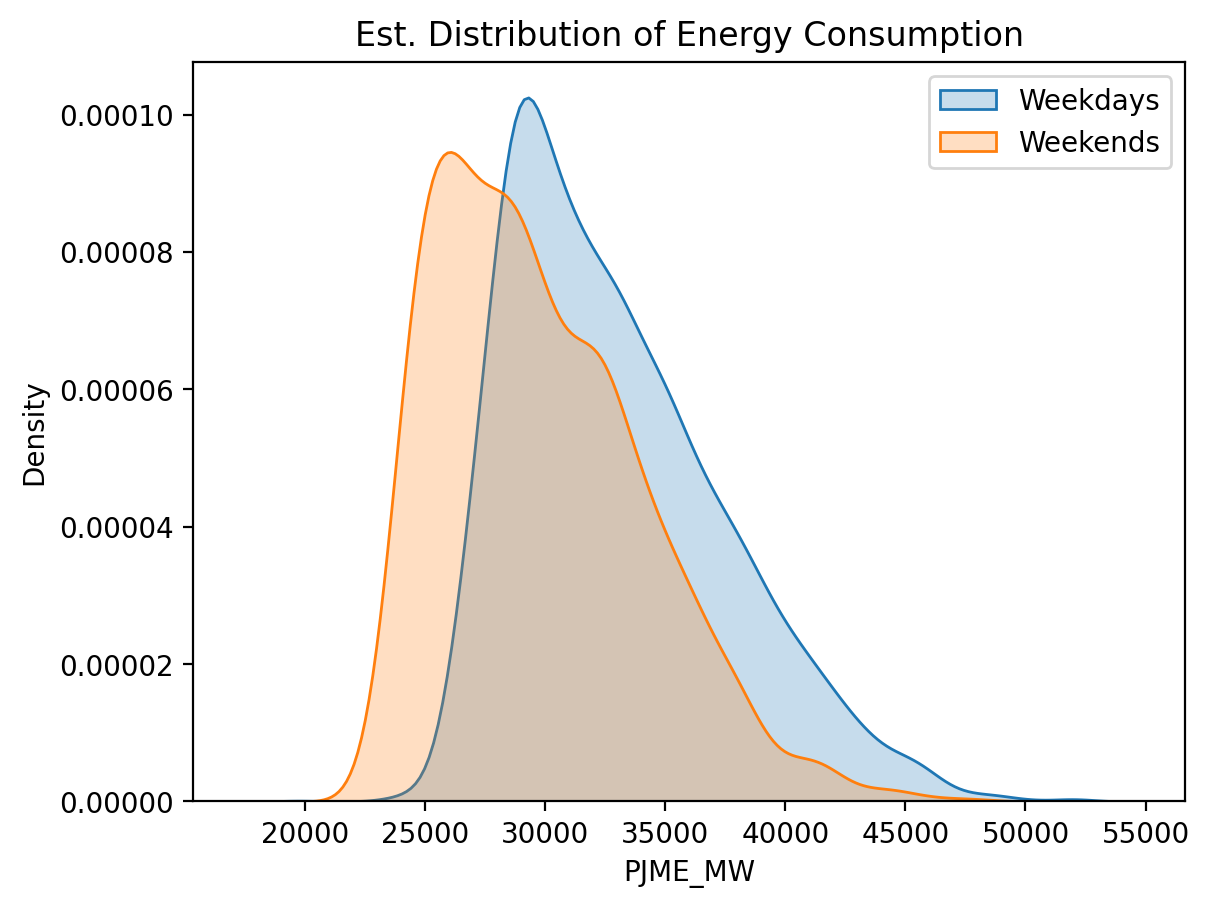

In [195]:
plt.figure(dpi=200)

sns.kdeplot(weekdays["PJME_MW"], fill=True, label="Weekdays")
sns.kdeplot(weekends["PJME_MW"], fill=True, label="Weekends")

plt.title("Est. Distribution of Energy Consumption")
plt.legend()
plt.show()

In [204]:
# Usando el t-test de Welch (más seguro por defecto):
t_stat, p_value = stats.ttest_ind(weekdays["PJME_MW"], weekends["PJME_MW"], equal_var=False)

print(f"p-value: {p_value * 100}% < 5%")
print(f"t-statistic: {t_stat:.4f}")

p-value: 3.91876651133751e-133% < 5%
t-statistic: 25.9183


In [202]:
print(f"Median weekdays consumption: {weekdays["PJME_MW"].median():.2f} MW")
print(f"Median weekends consumption: {weekends["PJME_MW"].median()} MW")

Median weekdays consumption: 32130.83 MW
Median weekends consumption: 29047.0 MW


### 5. Análisis de los Resultados:

Dado que el p-value es menor a 0.05 (3.91e-133%), se puede concluir que la diferencia en el consumo promedio entre los días laborables y los fines de semana es estadísticamente significativa; lo cual significa que los resultados no son producto del azar, lo cual tiene sentido. Además, a pesar de que el df es bastante grande, el t-statistic obtenido (25.91) parece que también lo es, lo que podría significar una gran diferencia entre la media de ambos grupos.

Calculando la mediana, se puede confirmar que lo que se vio tanto en el histograma como en el KDE, el consumo en días de entre semana es mayor al de los fines de semana — 32130.83 MW vs. 29047.0 MW —, pero como se observa, la diferencia no es demasiada, lo que sugiere que a pesar de que los fines de semana apenas ocupan el 28.5% aprox del total de la semana, la gente consume mucha energía, probeblemente en hobbies como amanecérsela jugando videojuegos o teniendo un maratón de peliculas/series.

Finalmente, aunque la diferencia es estadísticamente significativa, la magnitud de la diferencia (unos 3,000 MW) debe analizarse en el contexto del sistema eléctrico para evaluar su importancia práctica.